# Download the data

In [1]:
!wget http://www.cs.cmu.edu/~jiweil/review.txt.zip

!wget http://www.cs.cmu.edu/~jiweil/offering.txt.zip

!unzip review.txt.zip
!unzip offering.txt.zip
!mkdir /content/data/
!mkdir /content/data/tripadvisor
!mv review.txt /content/data/tripadvisor/review.txt
!mv offering.txt /content/data/tripadvisor/offering.txt

--2024-12-15 17:58:38--  http://www.cs.cmu.edu/~jiweil/review.txt.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373708772 (356M) [application/zip]
Saving to: ‘review.txt.zip’

review.txt.zip      100%[===================>] 356.40M  1.62MB/s    in 3m 30s  

2024-12-15 18:02:09 (1.70 MB/s) - ‘review.txt.zip’ saved [373708772/373708772]

--2024-12-15 18:02:09--  http://www.cs.cmu.edu/~jiweil/offering.txt.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175694 (172K) [application/zip]
Saving to: ‘offering.txt.zip’

offering.txt.zip    100%[===================>] 171.58K   890KB/s    in 0.2s    

2024-12-15 18:02:09 (890 KB/s) - ‘offering.txt.zip’ saved [175694/175694]

Archive:  review.txt.zip
  inflating: 

In [3]:
! pip install flashtext

  Preparing metadata (setup.py) ... done
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=782a38355e45b34cea78a94df4fc7a9514215c3411e6c1e2fd2f3d4f759ff8ee
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext


# Import Libraries

In [4]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from flashtext import KeywordProcessor
import zipfile

# Initialize tqdm for pandas
tqdm.pandas()


# Define Functions
## Load Data

In [5]:
def load_reviews(file_path):
    """Load reviews from a JSON file and normalize columns."""
    reviews = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in tqdm(file, desc="Loading reviews"):
            reviews.append(json.loads(line))
    df = pd.DataFrame(reviews)
    ratings_df = pd.json_normalize(df['ratings'])
    df = pd.concat([df.drop('ratings', axis=1), ratings_df], axis=1)
    return df


## Text Preprocessing

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    """Clean and lemmatize text using SpaCy."""
    cleaned_text = re.sub(r'[^a-z\s]', '', text.lower())
    doc = nlp(cleaned_text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_tokens)

def preprocess_reviews(df, text_column):
    """Preprocess the text column."""
    tqdm.pandas(desc="Preprocessing Text")
    df['text_processed'] = df[text_column].progress_apply(preprocess_text)
    return df

## Keyword Flagging

In [7]:
def flag_keywords(df, keywords, text_column):
    """Flag reviews containing mobility-related keywords using FlashText."""
    keyword_processor = KeywordProcessor()
    for keyword in keywords:
        keyword_processor.add_keyword(keyword)

    df['mobility_keywords_found'] = df[text_column].apply(keyword_processor.extract_keywords)
    df['mobility_related'] = df['mobility_keywords_found'].apply(lambda x: len(x) > 0)
    return df


## Sentiment Analysis

In [8]:
def analyze_sentiment(text):
    """Analyze sentiment using TextBlob."""
    return TextBlob(text).sentiment.polarity

def classify_sentiment(score):
    """Classify sentiment based on polarity score."""
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

def add_sentiment_analysis(df, text_column):
    """Add sentiment analysis columns."""
    tqdm.pandas(desc="Analyzing Sentiment")
    df['sentiment_score'] = df[text_column].progress_apply(analyze_sentiment)
    df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)
    return df


## Save and Load Processed Data

In [9]:
def save_processed_data(df, file_path):
    """Save processed DataFrame to a file."""
    df.to_pickle(file_path)
    print(f"Processed DataFrame saved to '{file_path}'")

def load_processed_data(file_path):
    """Load processed DataFrame from a file."""
    df = pd.read_pickle(file_path)
    print(f"Processed DataFrame loaded from '{file_path}'")
    return df


## Visualizations

In [10]:
def plot_wordcloud(df, text_column, title):
    """Generate a word cloud from the text column."""
    text = ' '.join(df[text_column])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def plot_sentiment_pie(df, sentiment_column, title):
    """Plot a pie chart for sentiment distribution."""
    sentiment_counts = df[sentiment_column].value_counts()
    colors = ['green', 'gold', 'red']
    sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(title)
    plt.ylabel('')
    plt.show()

def plot_keyword_frequency(df, keyword_column):
    """Plot keyword frequency."""
    all_keywords = [keyword for sublist in df[keyword_column] for keyword in sublist]
    keyword_counts = pd.DataFrame(all_keywords, columns=['keyword']).value_counts().reset_index(name='count')
    keyword_counts.columns = ['keyword', 'count']

    plt.figure(figsize=(12, 6))
    sns.barplot(data=keyword_counts.head(20), x='count', y='keyword', palette='Blues_d')
    plt.title('Top 20 Mobility-Related Keywords')
    plt.xlabel('Frequency')
    plt.ylabel('Keyword')
    plt.tight_layout()
    plt.show()

## Zip CSV Files
def zip_csv_files(file_names, zip_file_name):
    """Zip multiple CSV files."""
    with zipfile.ZipFile(zip_file_name, 'w') as zipf:
        for file in file_names:
            zipf.write(file)
    print(f"Zipped files into '{zip_file_name}'")



Loading reviews: 878561it [00:22, 39337.81it/s]
Analyzing Sentiment: 100%|██████████| 127670/127670 [02:37<00:00, 811.11it/s]


Processed DataFrame saved to 'processed_reviews_top_50.pkl'


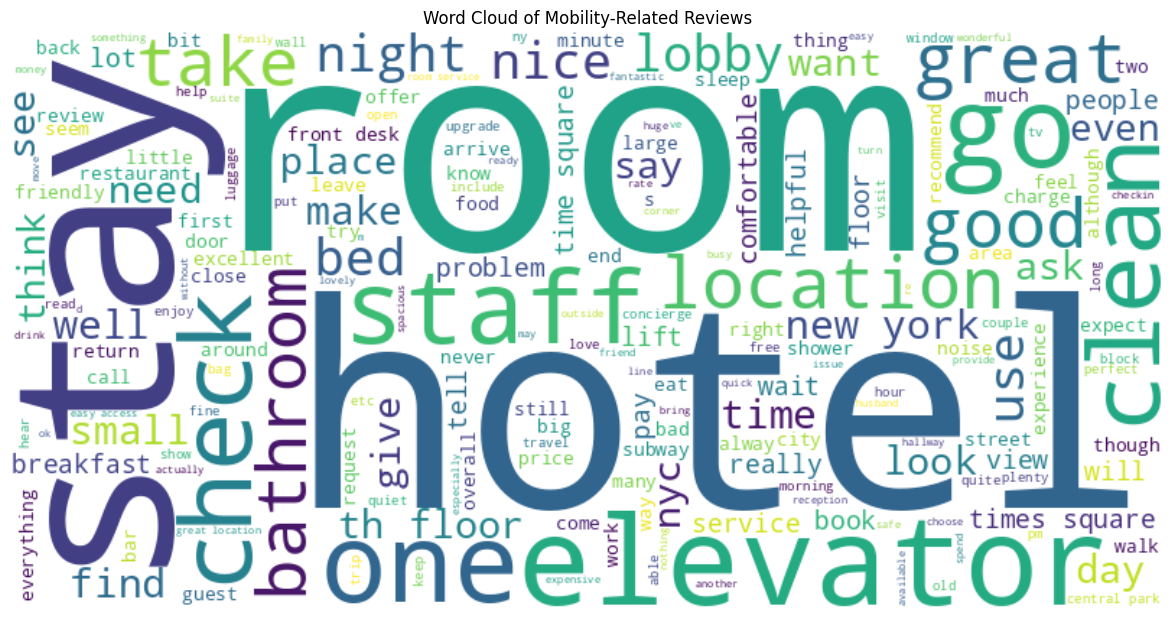

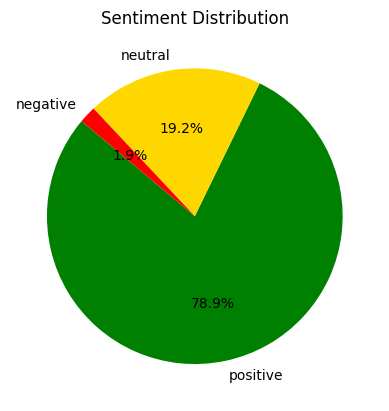

<ipython-input-10-3bfcca6d7f81>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=keyword_counts.head(20), x='count', y='keyword', palette='Blues_d')


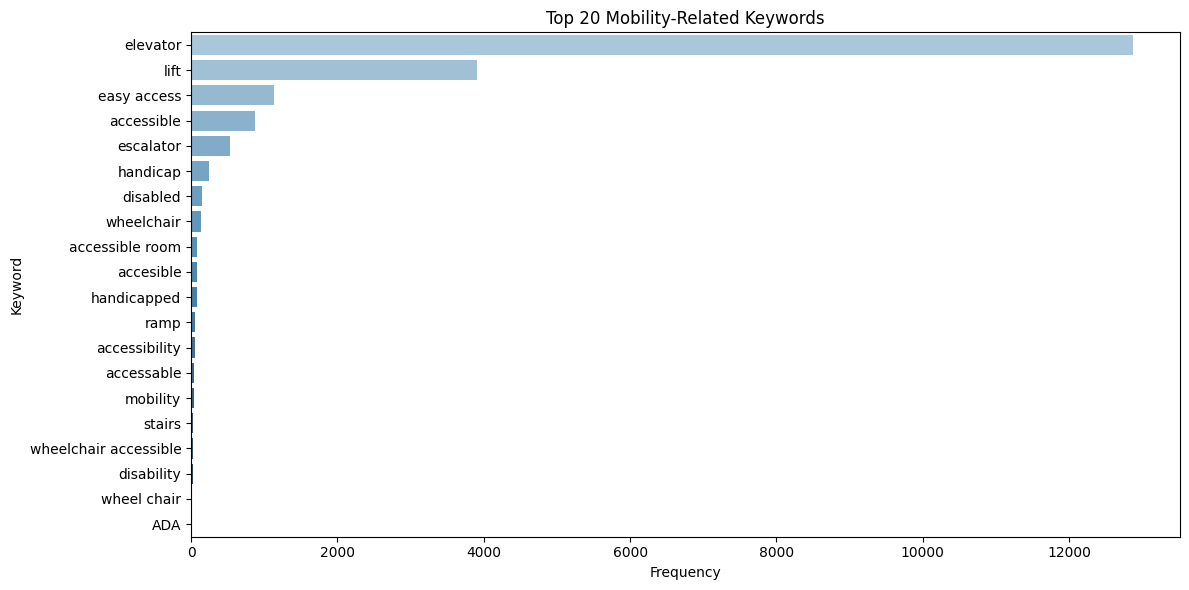

Zipped files into 'mobility_reviews_top_50.zip'


In [13]:
# Step 1: Load Data
df_reviews = load_reviews('/content/data/tripadvisor/review.txt')

# Step 2: Identify the Top 50 Hotels
reviews_per_hotel = df_reviews.groupby('offering_id').size().reset_index(name='num_reviews')
reviews_per_hotel_sorted = reviews_per_hotel.sort_values(by='num_reviews', ascending=False)
top_50_hotels = reviews_per_hotel_sorted.head(50)
selected_hotels = top_50_hotels['offering_id'].tolist()
df_selected = df_reviews[df_reviews['offering_id'].isin(selected_hotels)].copy()

# Step 3: Preprocess Text
df_selected = preprocess_reviews(df_selected, text_column='text')

# Step 4: Flag Mobility-Related Keywords
mobility_keywords = [
    # Wheelchair variations
    'wheelchair', 'wheel chair', 'wheel-chair',
    # Accessibility
    'accessible', 'accessibility', 'accessible room', 'accessible bathroom', 'accessible shower',
    # Elevator and Lift
    'elevator', 'lift', 'escalator',
    # Ramps
    'ramp', 'ramps',
    # Disability terms
    'disabled', 'disability', 'handicap', 'handicapped', 'mobility', 'mobility issues', 'mobility impaired',
    # Stairs and Steps
    'stairs', 'steps', 'no stairs', 'step-free', 'step free', 'no steps',
    # Barrier-free
    'barrier-free', 'barrier free', 'no barriers',
    # ADA Compliance
    'ADA', 'ADA compliant', 'ADA room', 'ADA accessible',
    # Bathroom aids
    'bathroom rails', 'grab bars', 'shower chair', 'roll-in shower', 'roll in shower',
    # Visual and Hearing Impairments
    'braille', 'hearing impaired', 'hearing impairment', 'visual impaired', 'visual impairment', 'tactile signs',
    # Service animals
    'guide dog', 'service dog', 'assistance dog',
    # Parking
    'handicap parking', 'accessible parking', 'disabled parking',
    # Accessible facilities
    'accessible entrance', 'accessible facilities', 'accessible amenities',
    # Equipment
    'mobility scooter', 'wheelchair accessible', 'accessible path',
    # Additional terms
    'easy access', 'limited mobility', 'accessible pool', 'accessible toilet', 'accessible seating',
    # Misspellings and variations
    'wheelchiar', 'accesible', 'accsesible', 'elevater', 'handi-cap', 'accessable',
]
df_selected = flag_keywords(df_selected, mobility_keywords, text_column='text_processed')

# Step 5: Add Sentiment Analysis
df_selected = add_sentiment_analysis(df_selected, text_column='text')

# Step 6: Save Processed Data
save_processed_data(df_selected, 'processed_reviews_top_50.pkl')

# Step 7: Visualizations
plot_wordcloud(df_selected[df_selected['mobility_related']], 'text_processed', 'Word Cloud of Mobility-Related Reviews')
plot_sentiment_pie(df_selected[df_selected['mobility_related']], 'sentiment', 'Sentiment Distribution')
plot_keyword_frequency(df_selected[df_selected['mobility_related']], 'mobility_keywords_found')

# Step 8: Save Filtered Data
df_selected[df_selected['mobility_related']].to_csv('mobility_related_reviews_top_50.csv', index=False)

# Step 9: Zip Files
zip_csv_files(['mobility_related_reviews_top_50.csv'], 'mobility_reviews_top_50.zip')
